# Построение модели для прогнозирования количества заказов такси

## Описание проекта

<u>**Цель проекта**</u>: Построение модели для предсказания спроса на услуги такси на основании анализа временных рядов;

<u>**Сферы деятельности компаний**</u>: Перевозка пассажиров;

<u>**Навыки и инструменты**</u>: Анализ временных рядов, создание признаков


## Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

## Оглавление:
#### 1. [Подготовка](#подготовка)
#### 2. [Анализ](#анализ)
#### 3. [Обучение](#обучение)
#### 4. [Результаты тестирования](#результаты_тестирования)
#### 5. [Общие выводы](#общие_выводы)

    
<a name="подготовка"></a>

# 1. Подготовка

In [1]:
# %load imports.py
#Основные библиотеки
import pandas as pd
import numpy as np
import math as m
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

#Параметры визуализации
from pylab import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'svg' #закомментировать в случае возникновения проблем :)
rcParams['figure.figsize'] = 12, 10
sns.set(rc={'figure.figsize':(14, 10)})

#Параметры отображения результатов выполнения кода в ячейках
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from ipywidgets import widgets
from IPython.display import display, clear_output

#Параметры предупреждений
import warnings
warnings.simplefilter('ignore')


#tqdm
from tqdm.notebook import tqdm

#time
import time 
import datetime

#ML
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, GridSearchCV,
                                     KFold, cross_val_score)

from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.utils import shuffle

from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import (LogisticRegression, LinearRegression,
                                  PassiveAggressiveClassifier, Perceptron)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (accuracy_score, r2_score, f1_score, mean_squared_error,
                             mean_absolute_error, precision_score, recall_score,
                             precision_recall_curve, confusion_matrix, roc_curve, roc_auc_score, 
                             make_scorer)

from sklearn.dummy import DummyClassifier

import joblib

In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import lightgbm as lgb

Откроем файл с данными, приведём даты к общему виду и сделаем их индексами датафрейма.

Отсортируем индексы, проверим монотонность:

In [4]:
data_taxi = pd.read_csv(..., index_col=[0], parse_dates=[0])

In [5]:
data_taxi.sort_index(inplace=True)
data_taxi.index.is_monotonic

True

In [6]:
data_taxi.head(30)
data_taxi.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
data_taxi.describe()
print('Пропусков в датафрейме: ', data_taxi.isna().sum().sum())

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Пропусков в датафрейме:  0


Индексы датафрейма изменяются монотонно, а столбец всего один, поэтому в нашем случае **искать дубликаты бессмысленно**: будет множество ложноположительных результатов, так как индексы учтены не будут, а количества заказов часто повторяются.

**Пропуски отсутствуют**.

Введём функцию *make_features*, принимающую на вход данные, максимальное отставание и объём подвыборок для вычисления скользящего среднего.

Значения параметров по умолчанию — 1.

В процессе создания новых признаков происходит автоматическое дополнение списка *numeric*, который в будущем пригодится нам для масштабирования.

In [8]:
def make_features(data, max_lag=1, rolling_mean_size=1):
    
    if max_lag == None:
        max_lag = 1
        
    if rolling_mean_size == None:
        rolling_mean_size = 1
        
    for lag in range(1, max_lag + 1):
        
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
        globals()['numeric'].append('lag_{}'.format(lag))
        
    data['rolling_mean_{}'.format(rolling_mean_size)] = (data['num_orders']
                                                    .shift()
                                                    .rolling(rolling_mean_size)
                                                    .mean())
    
    globals()['numeric'].append('rolling_mean_{}'.format(rolling_mean_size))

Выполним **ресемплинг**, зададим интервал, равный **1 ч**.

Просуммируем все закзы, которые попадают в заданные промежутки времени.

Из индексов "вытянем" **новые признаки** — '*month*', '*day*', '*hour*', '*dayofweek*'.

Создадим список 'numeric', в который будем записывать имена численных признаков.

In [9]:
data_taxi_r = pd.DataFrame.copy(data_taxi, deep=True).resample(rule='1H').sum()

data_taxi_r ['month'] = data_taxi_r.index.month
data_taxi_r ['day'] = data_taxi_r.index.day
data_taxi_r ['hour'] = data_taxi_r.index.hour
data_taxi_r ['dayofweek'] = data_taxi_r.index.dayofweek

numeric = ['month',
           'day',
           'hour',
           'dayofweek']

data_taxi_r
print('Численные признаки:')
numeric

,num_orders,month,day,hour,dayofweek
datetime,,,,,
2018-03-01 00:00:00,124,3,1,0,3
2018-03-01 01:00:00,85,3,1,1,3
2018-03-01 02:00:00,71,3,1,2,3
2018-03-01 03:00:00,66,3,1,3,3
2018-03-01 04:00:00,43,3,1,4,3
...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,19,4
2018-08-31 20:00:00,154,8,31,20,4
2018-08-31 21:00:00,159,8,31,21,4


Численные признаки:


['month', 'day', 'hour', 'dayofweek']

<div style="border: solid darkcyan 3px; padding: 30px">
<h3 style="color:black; margin-bottom:25px"> Выводы: </h3>
    <ul>
        <li><b>Загружен датасет, получена общая информация</b>;</li>
        <li><b>Даты приведены к общему формату и использованы в качестве индексов датафрейма</b>;</li>
        <li><b>Изменение значений индексов монотонное, пропуски и дубликаты отсутствуют</b>;</li>
        <li><b>Написана функция <i>make_features</i> для создания новых признаков</b>;</li>
        <li><b>Создан список численных признаков для масштабирования</b>;</li>
        <li><b>Выполнен ресемплинг с интервалом продолжительностью 1 ч</b>.</li>
    </ul>
</div>


#### [К оглавлению](#оглавление)

<a name="анализ"></a>
# 2. Анализ

Для корректной визуализации данных вернём параметр *ast_node_interactivity* к стандартному значению:

In [10]:
InteractiveShell.ast_node_interactivity = 'last_expr'

Взглянем на распределения количеств заказов:

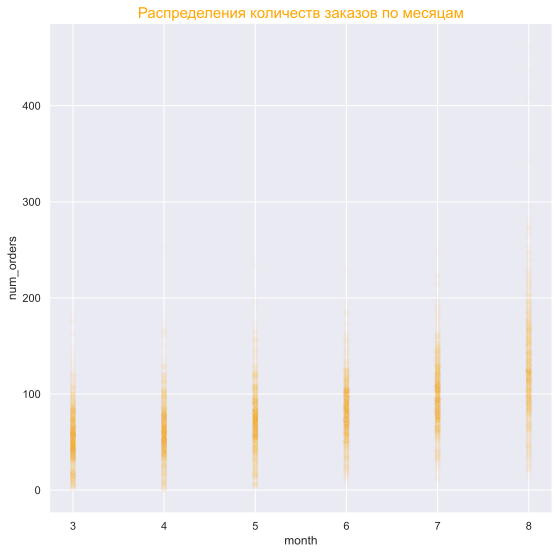

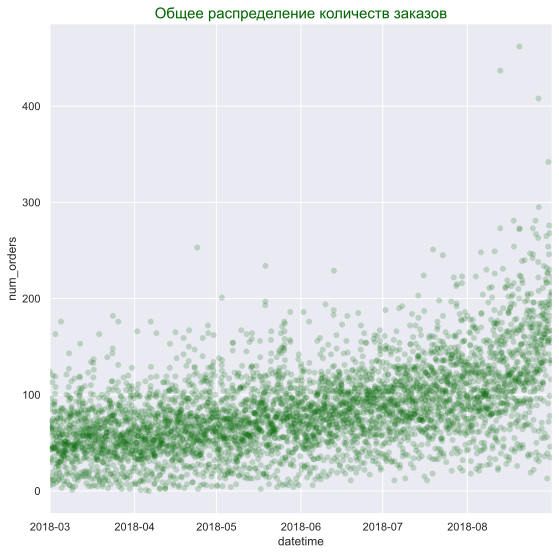

In [11]:
f, ax = plt.subplots(figsize=(9, 9))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='month', y='num_orders',
                color='orange',
                sizes=(1, 8),
                linewidth=0,
                alpha=0.02,
                data=data_taxi_r, ax=ax)
plt.title("Распределения количеств заказов по месяцам",
                                 fontsize=15,
                                 color='orange')
plt.show()

f, ax = plt.subplots(figsize=(9, 9))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x=data_taxi_r.index,
                y='num_orders',
                color='darkgreen',
                sizes=(1, 8),
                linewidth=0,
                alpha=0.2,
                data=data_taxi_r, ax=ax).set_xlim(data_taxi_r.index.min(), data_taxi_r.index.max())
plt.title("Общее распределение количеств заказов",
                                 fontsize=15,
                                 color='darkgreen')
plt.show()

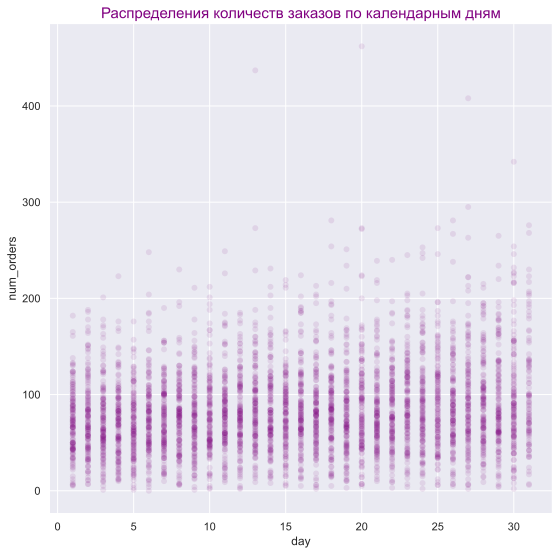

In [12]:

f, ax = plt.subplots(figsize=(9, 9))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='day', y='num_orders',
                color='purple',
                sizes=(1, 8),
                linewidth=0,
                alpha=0.1,
                data=data_taxi_r, ax=ax)
plt.title("Распределения количеств заказов по календарным дням",
                                 fontsize=15,
                                 color='purple')
plt.show()

**Количество заказов наименьшим образом зависит от текущего календарного дня**, что вполне объяснимо.

Зависимость от дней недели наверняка будет более явной:

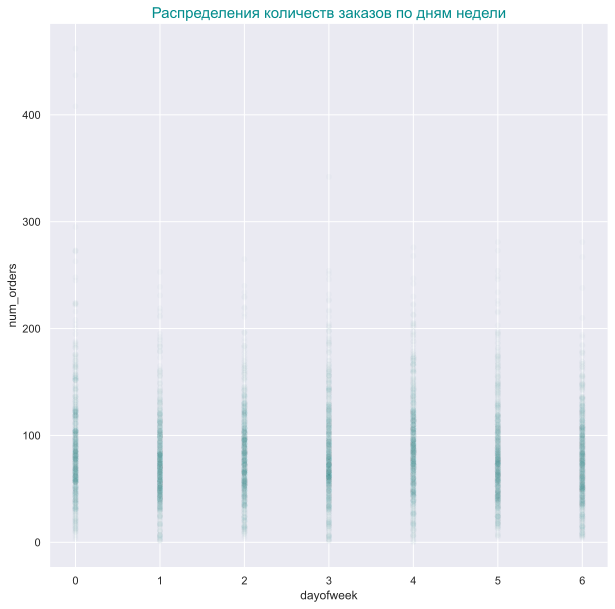

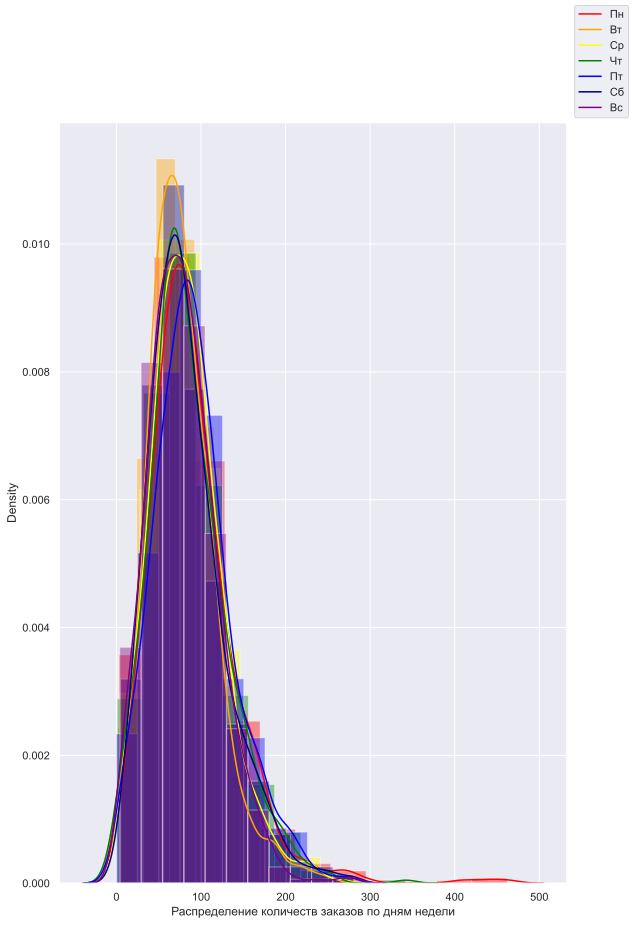

In [13]:
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='dayofweek', y='num_orders',
                color='darkcyan',
                sizes=(1, 8),
                linewidth=0,
                alpha=0.02,
                data=data_taxi_r, ax=ax)
plt.title("Распределения количеств заказов по дням недели",
                                 fontsize=15,
                                 color='darkcyan')
plt.show()

plot_dict = {0:'red',
             1:'orange',
             2:'yellow',
             3:'green',
             4:'blue',
             5:'darkblue',
             6:'purple'}

fig = plt.figure(figsize=(9.1, 14))

for day, color in plot_dict.items():
    sns.distplot(data_taxi_r[data_taxi_r['dayofweek'] == day]['num_orders'],
                 bins=np.int64(np.ceil(1 + m.log2(len(data_taxi_r[data_taxi_r['dayofweek'] == 2])))),
                 kde=True,
                 color=color,
                 norm_hist=True,
                 axlabel='Распределение количеств заказов по дням недели')
fig.legend(labels=['Пн','Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()

**Наибольшие количества заказов приходятся на конец рабочей недели — пятницу, — а также на выходные. Для начала рабочей недели, напротив, характерно наименьшая востребованность такси.**

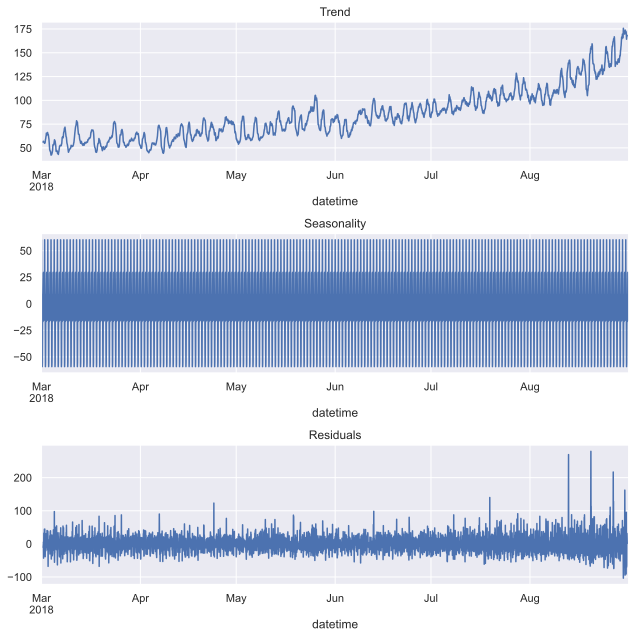

In [14]:
decomposed = seasonal_decompose(data_taxi_r['num_orders'])

plt.figure(figsize=(9, 9))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
plt.show()

На сезонной составляющей видны цикличные изменения, создаваемые, в первую очередь, днями недели.

В декомпозиционном остатке ближе к концу датасета видны шумы с большей амплитудой.

In [15]:
InteractiveShell.ast_node_interactivity = 'all'

<div style="border: solid darkcyan 3px; padding: 30px">
<h3 style="color:black; margin-bottom:25px"> Выводы: </h3>
    <ul>
        <li><b>Проанализированы зависимости количеств заказов от различных факторов</b>;</li>
        <li><b>С марта по август наблюдается увеличение количеств заказов</b>;</li>
        <li><b>Цикличные изменения сезонной составляющей сильнее всего зависимы от дня недели</b>.</li>
    </ul>
</div>

#### [К оглавлению](#оглавление)

<a name="обучение"></a>
# 3. Обучение

Обучим **линейную регрессию**, создавая в цикле датафреймы, содержащие **различные количества признаков**. 

Будем изменять **максимальные отставания** и **объёмы подвыборок для вычисления скользящего среднего**.

Для тестирования используем метрику **RMSE**.

Результаты будем сохранять в отдельный датафрейм:

In [16]:
results_columns = ['max_lag', 'rolling_mean_size', 'rmse']
state = 'error'
while state == 'error':
    try:
        results = []
        for max_lag in tqdm(range(1, 51)):
            for rolling_mean_size in range(1, 51):

                numeric = ['month',
                           'day',
                           'hour',
                           'dayofweek']

                data_taxi_f = pd.DataFrame.copy(data_taxi_r, deep=True)
                
                make_features(data=data_taxi_f,
                              max_lag=max_lag,
                              rolling_mean_size=rolling_mean_size)

                data_taxi_f = data_taxi_f.dropna()

                data_taxi_train, data_taxi_test = train_test_split(data_taxi_f,
                                                                   shuffle=False,
                                                                   test_size=0.1)

                scaler = StandardScaler().fit(data_taxi_train[numeric])
                data_taxi_train[numeric] = scaler.transform(data_taxi_train[numeric])
                data_taxi_test[numeric] = scaler.transform(data_taxi_test[numeric])

                features_train = data_taxi_train.drop(['num_orders'], axis=1)
                features_test = data_taxi_test.drop(['num_orders'], axis=1)
                target_train = data_taxi_train['num_orders']
                target_test = data_taxi_test['num_orders']

                predictions = (LinearRegression()
                               .fit(features_train, target_train)
                               .predict(features_test))

                rmse = mean_squared_error(target_test, predictions)**0.5
                
                results.append([max_lag, rolling_mean_size, rmse])

                print('max_lag={}, rolling_mean_size={}, RMSE: {:.4f}'
                      .format(max_lag, rolling_mean_size, rmse))
                
                globals()['state'] = 'executed'
        results_df = pd.DataFrame(data=results, columns=results_columns)
    except:
        state = 'error'
        clear_output()

max_lag=1, rolling_mean_size=1, RMSE: 53.0664
max_lag=1, rolling_mean_size=2, RMSE: 52.7227
max_lag=1, rolling_mean_size=3, RMSE: 52.8248
max_lag=1, rolling_mean_size=4, RMSE: 52.8597
max_lag=1, rolling_mean_size=5, RMSE: 52.9614
max_lag=1, rolling_mean_size=6, RMSE: 53.2881
max_lag=1, rolling_mean_size=7, RMSE: 53.3428
max_lag=1, rolling_mean_size=8, RMSE: 53.3518
max_lag=1, rolling_mean_size=9, RMSE: 53.6647
max_lag=1, rolling_mean_size=10, RMSE: 53.6808
max_lag=1, rolling_mean_size=11, RMSE: 53.5118
max_lag=1, rolling_mean_size=12, RMSE: 53.3850
max_lag=1, rolling_mean_size=13, RMSE: 53.4287
max_lag=1, rolling_mean_size=14, RMSE: 53.8236
max_lag=1, rolling_mean_size=15, RMSE: 54.2341
max_lag=1, rolling_mean_size=16, RMSE: 54.1134
max_lag=1, rolling_mean_size=17, RMSE: 54.4795
max_lag=1, rolling_mean_size=18, RMSE: 55.0637
max_lag=1, rolling_mean_size=19, RMSE: 55.5852
max_lag=1, rolling_mean_size=20, RMSE: 56.0765
max_lag=1, rolling_mean_size=21, RMSE: 56.2198
max_lag=1, rolling_mea

max_lag=4, rolling_mean_size=30, RMSE: 52.2899
max_lag=4, rolling_mean_size=31, RMSE: 52.4630
max_lag=4, rolling_mean_size=32, RMSE: 52.5885
max_lag=4, rolling_mean_size=33, RMSE: 53.1184
max_lag=4, rolling_mean_size=34, RMSE: 53.3933
max_lag=4, rolling_mean_size=35, RMSE: 53.3564
max_lag=4, rolling_mean_size=36, RMSE: 53.3952
max_lag=4, rolling_mean_size=37, RMSE: 53.5797
max_lag=4, rolling_mean_size=38, RMSE: 54.1667
max_lag=4, rolling_mean_size=39, RMSE: 54.6382
max_lag=4, rolling_mean_size=40, RMSE: 54.6578
max_lag=4, rolling_mean_size=41, RMSE: 55.1409
max_lag=4, rolling_mean_size=42, RMSE: 56.0516
max_lag=4, rolling_mean_size=43, RMSE: 56.7051
max_lag=4, rolling_mean_size=44, RMSE: 57.4504
max_lag=4, rolling_mean_size=45, RMSE: 57.4455
max_lag=4, rolling_mean_size=46, RMSE: 56.4222
max_lag=4, rolling_mean_size=47, RMSE: 54.3018
max_lag=4, rolling_mean_size=48, RMSE: 51.6378
max_lag=4, rolling_mean_size=49, RMSE: 51.1870
max_lag=4, rolling_mean_size=50, RMSE: 51.1240
max_lag=5, ro

max_lag=8, rolling_mean_size=6, RMSE: 52.6823
max_lag=8, rolling_mean_size=7, RMSE: 52.6823
max_lag=8, rolling_mean_size=8, RMSE: 52.6823
max_lag=8, rolling_mean_size=9, RMSE: 53.5305
max_lag=8, rolling_mean_size=10, RMSE: 53.2661
max_lag=8, rolling_mean_size=11, RMSE: 52.9892
max_lag=8, rolling_mean_size=12, RMSE: 52.8005
max_lag=8, rolling_mean_size=13, RMSE: 52.8411
max_lag=8, rolling_mean_size=14, RMSE: 53.2783
max_lag=8, rolling_mean_size=15, RMSE: 53.7495
max_lag=8, rolling_mean_size=16, RMSE: 53.5280
max_lag=8, rolling_mean_size=17, RMSE: 53.8261
max_lag=8, rolling_mean_size=18, RMSE: 54.4353
max_lag=8, rolling_mean_size=19, RMSE: 54.9889
max_lag=8, rolling_mean_size=20, RMSE: 55.5443
max_lag=8, rolling_mean_size=21, RMSE: 55.7360
max_lag=8, rolling_mean_size=22, RMSE: 55.0028
max_lag=8, rolling_mean_size=23, RMSE: 53.5250
max_lag=8, rolling_mean_size=24, RMSE: 51.3087
max_lag=8, rolling_mean_size=25, RMSE: 50.9229
max_lag=8, rolling_mean_size=26, RMSE: 51.1144
max_lag=8, rollin

max_lag=11, rolling_mean_size=30, RMSE: 52.1350
max_lag=11, rolling_mean_size=31, RMSE: 52.3415
max_lag=11, rolling_mean_size=32, RMSE: 52.4647
max_lag=11, rolling_mean_size=33, RMSE: 52.8325
max_lag=11, rolling_mean_size=34, RMSE: 53.0619
max_lag=11, rolling_mean_size=35, RMSE: 53.1936
max_lag=11, rolling_mean_size=36, RMSE: 53.3959
max_lag=11, rolling_mean_size=37, RMSE: 53.7019
max_lag=11, rolling_mean_size=38, RMSE: 54.3462
max_lag=11, rolling_mean_size=39, RMSE: 54.8542
max_lag=11, rolling_mean_size=40, RMSE: 54.8101
max_lag=11, rolling_mean_size=41, RMSE: 55.1564
max_lag=11, rolling_mean_size=42, RMSE: 56.0427
max_lag=11, rolling_mean_size=43, RMSE: 56.7187
max_lag=11, rolling_mean_size=44, RMSE: 57.4217
max_lag=11, rolling_mean_size=45, RMSE: 57.3679
max_lag=11, rolling_mean_size=46, RMSE: 56.2702
max_lag=11, rolling_mean_size=47, RMSE: 54.2262
max_lag=11, rolling_mean_size=48, RMSE: 51.6457
max_lag=11, rolling_mean_size=49, RMSE: 51.1952
max_lag=11, rolling_mean_size=50, RMSE: 

max_lag=15, rolling_mean_size=8, RMSE: 54.1482
max_lag=15, rolling_mean_size=9, RMSE: 54.1482
max_lag=15, rolling_mean_size=10, RMSE: 54.1482
max_lag=15, rolling_mean_size=11, RMSE: 54.1482
max_lag=15, rolling_mean_size=12, RMSE: 54.1482
max_lag=15, rolling_mean_size=13, RMSE: 54.1482
max_lag=15, rolling_mean_size=14, RMSE: 54.1482
max_lag=15, rolling_mean_size=15, RMSE: 54.1482
max_lag=15, rolling_mean_size=16, RMSE: 53.3127
max_lag=15, rolling_mean_size=17, RMSE: 53.6398
max_lag=15, rolling_mean_size=18, RMSE: 54.3877
max_lag=15, rolling_mean_size=19, RMSE: 54.8649
max_lag=15, rolling_mean_size=20, RMSE: 55.3422
max_lag=15, rolling_mean_size=21, RMSE: 55.5183
max_lag=15, rolling_mean_size=22, RMSE: 54.6696
max_lag=15, rolling_mean_size=23, RMSE: 52.6583
max_lag=15, rolling_mean_size=24, RMSE: 50.1690
max_lag=15, rolling_mean_size=25, RMSE: 49.8420
max_lag=15, rolling_mean_size=26, RMSE: 50.0688
max_lag=15, rolling_mean_size=27, RMSE: 50.7818
max_lag=15, rolling_mean_size=28, RMSE: 51

max_lag=18, rolling_mean_size=30, RMSE: 50.9305
max_lag=18, rolling_mean_size=31, RMSE: 51.1568
max_lag=18, rolling_mean_size=32, RMSE: 51.3486
max_lag=18, rolling_mean_size=33, RMSE: 51.8629
max_lag=18, rolling_mean_size=34, RMSE: 52.1408
max_lag=18, rolling_mean_size=35, RMSE: 52.3376
max_lag=18, rolling_mean_size=36, RMSE: 52.5383
max_lag=18, rolling_mean_size=37, RMSE: 52.7572
max_lag=18, rolling_mean_size=38, RMSE: 53.1555
max_lag=18, rolling_mean_size=39, RMSE: 53.4133
max_lag=18, rolling_mean_size=40, RMSE: 53.3176
max_lag=18, rolling_mean_size=41, RMSE: 53.5354
max_lag=18, rolling_mean_size=42, RMSE: 54.1561
max_lag=18, rolling_mean_size=43, RMSE: 54.8050
max_lag=18, rolling_mean_size=44, RMSE: 55.5802
max_lag=18, rolling_mean_size=45, RMSE: 55.5651
max_lag=18, rolling_mean_size=46, RMSE: 54.5086
max_lag=18, rolling_mean_size=47, RMSE: 52.6225
max_lag=18, rolling_mean_size=48, RMSE: 50.1998
max_lag=18, rolling_mean_size=49, RMSE: 49.8010
max_lag=18, rolling_mean_size=50, RMSE: 

max_lag=22, rolling_mean_size=4, RMSE: 51.0487
max_lag=22, rolling_mean_size=5, RMSE: 51.0410
max_lag=22, rolling_mean_size=6, RMSE: 51.0452
max_lag=22, rolling_mean_size=7, RMSE: 51.0478
max_lag=22, rolling_mean_size=8, RMSE: 51.0495
max_lag=22, rolling_mean_size=9, RMSE: 51.0500
max_lag=22, rolling_mean_size=10, RMSE: 51.0490
max_lag=22, rolling_mean_size=11, RMSE: 51.0495
max_lag=22, rolling_mean_size=12, RMSE: 51.0332
max_lag=22, rolling_mean_size=13, RMSE: 51.0468
max_lag=22, rolling_mean_size=14, RMSE: 51.0474
max_lag=22, rolling_mean_size=15, RMSE: 51.0423
max_lag=22, rolling_mean_size=16, RMSE: 51.0574
max_lag=22, rolling_mean_size=17, RMSE: 51.0345
max_lag=22, rolling_mean_size=18, RMSE: 51.0507
max_lag=22, rolling_mean_size=19, RMSE: 51.0489
max_lag=22, rolling_mean_size=20, RMSE: 51.0554
max_lag=22, rolling_mean_size=21, RMSE: 51.0498
max_lag=22, rolling_mean_size=22, RMSE: 51.0433
max_lag=22, rolling_mean_size=23, RMSE: 47.1033
max_lag=22, rolling_mean_size=24, RMSE: 44.603

max_lag=25, rolling_mean_size=29, RMSE: 47.0084
max_lag=25, rolling_mean_size=30, RMSE: 47.1186
max_lag=25, rolling_mean_size=31, RMSE: 47.3808
max_lag=25, rolling_mean_size=32, RMSE: 47.7426
max_lag=25, rolling_mean_size=33, RMSE: 47.9963
max_lag=25, rolling_mean_size=34, RMSE: 48.3680
max_lag=25, rolling_mean_size=35, RMSE: 48.6550
max_lag=25, rolling_mean_size=36, RMSE: 48.8010
max_lag=25, rolling_mean_size=37, RMSE: 48.9753
max_lag=25, rolling_mean_size=38, RMSE: 49.1697
max_lag=25, rolling_mean_size=39, RMSE: 49.4125
max_lag=25, rolling_mean_size=40, RMSE: 49.3568
max_lag=25, rolling_mean_size=41, RMSE: 49.4238
max_lag=25, rolling_mean_size=42, RMSE: 49.5795
max_lag=25, rolling_mean_size=43, RMSE: 49.4678
max_lag=25, rolling_mean_size=44, RMSE: 49.5849
max_lag=25, rolling_mean_size=45, RMSE: 49.4832
max_lag=25, rolling_mean_size=46, RMSE: 49.2592
max_lag=25, rolling_mean_size=47, RMSE: 48.5483
max_lag=25, rolling_mean_size=48, RMSE: 47.1676
max_lag=25, rolling_mean_size=49, RMSE: 

max_lag=29, rolling_mean_size=4, RMSE: 46.8204
max_lag=29, rolling_mean_size=5, RMSE: 46.8192
max_lag=29, rolling_mean_size=6, RMSE: 46.8197
max_lag=29, rolling_mean_size=7, RMSE: 46.8191
max_lag=29, rolling_mean_size=8, RMSE: 46.8213
max_lag=29, rolling_mean_size=9, RMSE: 46.8265
max_lag=29, rolling_mean_size=10, RMSE: 46.8177
max_lag=29, rolling_mean_size=11, RMSE: 46.8181
max_lag=29, rolling_mean_size=12, RMSE: 46.8189
max_lag=29, rolling_mean_size=13, RMSE: 46.8197
max_lag=29, rolling_mean_size=14, RMSE: 46.8188
max_lag=29, rolling_mean_size=15, RMSE: 46.8282
max_lag=29, rolling_mean_size=16, RMSE: 46.8354
max_lag=29, rolling_mean_size=17, RMSE: 46.8304
max_lag=29, rolling_mean_size=18, RMSE: 46.8211
max_lag=29, rolling_mean_size=19, RMSE: 46.8252
max_lag=29, rolling_mean_size=20, RMSE: 46.8179
max_lag=29, rolling_mean_size=21, RMSE: 46.8258
max_lag=29, rolling_mean_size=22, RMSE: 46.8177
max_lag=29, rolling_mean_size=23, RMSE: 46.8187
max_lag=29, rolling_mean_size=24, RMSE: 46.825

max_lag=32, rolling_mean_size=26, RMSE: 47.3957
max_lag=32, rolling_mean_size=27, RMSE: 47.3976
max_lag=32, rolling_mean_size=28, RMSE: 47.3891
max_lag=32, rolling_mean_size=29, RMSE: 47.3934
max_lag=32, rolling_mean_size=30, RMSE: 47.3982
max_lag=32, rolling_mean_size=31, RMSE: 47.3948
max_lag=32, rolling_mean_size=32, RMSE: 47.3981
max_lag=32, rolling_mean_size=33, RMSE: 47.5898
max_lag=32, rolling_mean_size=34, RMSE: 47.9926
max_lag=32, rolling_mean_size=35, RMSE: 48.2526
max_lag=32, rolling_mean_size=36, RMSE: 48.3498
max_lag=32, rolling_mean_size=37, RMSE: 48.4618
max_lag=32, rolling_mean_size=38, RMSE: 48.6172
max_lag=32, rolling_mean_size=39, RMSE: 48.7468
max_lag=32, rolling_mean_size=40, RMSE: 48.5668
max_lag=32, rolling_mean_size=41, RMSE: 48.5545
max_lag=32, rolling_mean_size=42, RMSE: 48.7061
max_lag=32, rolling_mean_size=43, RMSE: 48.5615
max_lag=32, rolling_mean_size=44, RMSE: 48.6874
max_lag=32, rolling_mean_size=45, RMSE: 48.5688
max_lag=32, rolling_mean_size=46, RMSE: 

max_lag=35, rolling_mean_size=48, RMSE: 45.5406
max_lag=35, rolling_mean_size=49, RMSE: 45.4067
max_lag=35, rolling_mean_size=50, RMSE: 45.3687
max_lag=36, rolling_mean_size=1, RMSE: 48.2812
max_lag=36, rolling_mean_size=2, RMSE: 48.2563
max_lag=36, rolling_mean_size=3, RMSE: 48.2586
max_lag=36, rolling_mean_size=4, RMSE: 48.2611
max_lag=36, rolling_mean_size=5, RMSE: 48.2719
max_lag=36, rolling_mean_size=6, RMSE: 48.2422
max_lag=36, rolling_mean_size=7, RMSE: 48.2539
max_lag=36, rolling_mean_size=8, RMSE: 48.2709
max_lag=36, rolling_mean_size=9, RMSE: 48.2619
max_lag=36, rolling_mean_size=10, RMSE: 48.2485
max_lag=36, rolling_mean_size=11, RMSE: 48.2448
max_lag=36, rolling_mean_size=12, RMSE: 48.2664
max_lag=36, rolling_mean_size=13, RMSE: 48.2566
max_lag=36, rolling_mean_size=14, RMSE: 48.2554
max_lag=36, rolling_mean_size=15, RMSE: 48.2488
max_lag=36, rolling_mean_size=16, RMSE: 48.2444
max_lag=36, rolling_mean_size=17, RMSE: 48.2580
max_lag=36, rolling_mean_size=18, RMSE: 48.2342
m

max_lag=39, rolling_mean_size=20, RMSE: 48.4342
max_lag=39, rolling_mean_size=21, RMSE: 48.4072
max_lag=39, rolling_mean_size=22, RMSE: 48.4218
max_lag=39, rolling_mean_size=23, RMSE: 48.4130
max_lag=39, rolling_mean_size=24, RMSE: 48.4147
max_lag=39, rolling_mean_size=25, RMSE: 48.4144
max_lag=39, rolling_mean_size=26, RMSE: 48.4010
max_lag=39, rolling_mean_size=27, RMSE: 48.4160
max_lag=39, rolling_mean_size=28, RMSE: 48.4232
max_lag=39, rolling_mean_size=29, RMSE: 48.4215
max_lag=39, rolling_mean_size=30, RMSE: 48.4221
max_lag=39, rolling_mean_size=31, RMSE: 48.4150
max_lag=39, rolling_mean_size=32, RMSE: 48.4226
max_lag=39, rolling_mean_size=33, RMSE: 48.4223
max_lag=39, rolling_mean_size=34, RMSE: 48.4263
max_lag=39, rolling_mean_size=35, RMSE: 48.4126
max_lag=39, rolling_mean_size=36, RMSE: 48.4447
max_lag=39, rolling_mean_size=37, RMSE: 48.4292
max_lag=39, rolling_mean_size=38, RMSE: 48.4172
max_lag=39, rolling_mean_size=39, RMSE: 48.4239
max_lag=39, rolling_mean_size=40, RMSE: 

max_lag=42, rolling_mean_size=44, RMSE: 48.0312
max_lag=42, rolling_mean_size=45, RMSE: 47.8162
max_lag=42, rolling_mean_size=46, RMSE: 47.2641
max_lag=42, rolling_mean_size=47, RMSE: 46.4129
max_lag=42, rolling_mean_size=48, RMSE: 44.7412
max_lag=42, rolling_mean_size=49, RMSE: 44.6504
max_lag=42, rolling_mean_size=50, RMSE: 44.7128
max_lag=43, rolling_mean_size=1, RMSE: 47.8731
max_lag=43, rolling_mean_size=2, RMSE: 47.8734
max_lag=43, rolling_mean_size=3, RMSE: 47.8764
max_lag=43, rolling_mean_size=4, RMSE: 47.8672
max_lag=43, rolling_mean_size=5, RMSE: 47.8983
max_lag=43, rolling_mean_size=6, RMSE: 47.8745
max_lag=43, rolling_mean_size=7, RMSE: 47.8884
max_lag=43, rolling_mean_size=8, RMSE: 47.8665
max_lag=43, rolling_mean_size=9, RMSE: 47.8796
max_lag=43, rolling_mean_size=10, RMSE: 47.8731
max_lag=43, rolling_mean_size=11, RMSE: 47.8743
max_lag=43, rolling_mean_size=12, RMSE: 47.8680
max_lag=43, rolling_mean_size=13, RMSE: 47.8715
max_lag=43, rolling_mean_size=14, RMSE: 47.8761
m

max_lag=46, rolling_mean_size=18, RMSE: 46.8346
max_lag=46, rolling_mean_size=19, RMSE: 46.8153
max_lag=46, rolling_mean_size=20, RMSE: 46.7945
max_lag=46, rolling_mean_size=21, RMSE: 46.8097
max_lag=46, rolling_mean_size=22, RMSE: 46.8316
max_lag=46, rolling_mean_size=23, RMSE: 46.7990
max_lag=46, rolling_mean_size=24, RMSE: 46.7971
max_lag=46, rolling_mean_size=25, RMSE: 46.8088
max_lag=46, rolling_mean_size=26, RMSE: 46.8084
max_lag=46, rolling_mean_size=27, RMSE: 46.8107
max_lag=46, rolling_mean_size=28, RMSE: 46.8094
max_lag=46, rolling_mean_size=29, RMSE: 46.8084
max_lag=46, rolling_mean_size=30, RMSE: 46.8092
max_lag=46, rolling_mean_size=31, RMSE: 46.8026
max_lag=46, rolling_mean_size=32, RMSE: 46.7998
max_lag=46, rolling_mean_size=33, RMSE: 46.8113
max_lag=46, rolling_mean_size=34, RMSE: 46.8080
max_lag=46, rolling_mean_size=35, RMSE: 46.8093
max_lag=46, rolling_mean_size=36, RMSE: 46.8015
max_lag=46, rolling_mean_size=37, RMSE: 46.8149
max_lag=46, rolling_mean_size=38, RMSE: 

max_lag=49, rolling_mean_size=41, RMSE: 43.2849
max_lag=49, rolling_mean_size=42, RMSE: 43.2745
max_lag=49, rolling_mean_size=43, RMSE: 43.2787
max_lag=49, rolling_mean_size=44, RMSE: 43.2789
max_lag=49, rolling_mean_size=45, RMSE: 43.2769
max_lag=49, rolling_mean_size=46, RMSE: 43.2873
max_lag=49, rolling_mean_size=47, RMSE: 43.2671
max_lag=49, rolling_mean_size=48, RMSE: 43.2775
max_lag=49, rolling_mean_size=49, RMSE: 43.2785
max_lag=49, rolling_mean_size=50, RMSE: 43.2807
max_lag=50, rolling_mean_size=1, RMSE: 43.2795
max_lag=50, rolling_mean_size=2, RMSE: 43.2806
max_lag=50, rolling_mean_size=3, RMSE: 43.2828
max_lag=50, rolling_mean_size=4, RMSE: 43.2823
max_lag=50, rolling_mean_size=5, RMSE: 43.2809
max_lag=50, rolling_mean_size=6, RMSE: 43.2808
max_lag=50, rolling_mean_size=7, RMSE: 43.2832
max_lag=50, rolling_mean_size=8, RMSE: 43.2976
max_lag=50, rolling_mean_size=9, RMSE: 43.2815
max_lag=50, rolling_mean_size=10, RMSE: 43.2886
max_lag=50, rolling_mean_size=11, RMSE: 43.2746
m

<div style="border: solid darkcyan 3px; padding: 30px">
<h3 style="color:black; margin-bottom:25px"> Выводы: </h3>
    <ul>
        <li><b>В качестве основной модели выбрана линейная регрессия</b>;</li>
        <li><b>Обучены 2500 моделей на различном количестве сгенерированных признаков, выполнена оценка с использованием метрики RMSE</b>.</li>
    </ul>
</div>

#### [К оглавлению](#оглавление)

<a name="результаты_тестирования"></a>
# 4. Результаты тестирования

Подведём итоги:

In [17]:
results_df

results_df[(results_df['rmse'] <= 48) & (results_df['rmse'] >= 47.99)]

results_df[results_df['rmse'] == results_df['rmse'].min()]

,max_lag,rolling_mean_size,rmse
0,1,1,53.066438
1,1,2,52.722678
2,1,3,52.824761
3,1,4,52.859671
4,1,5,52.961357
...,...,...,...
2495,50,46,43.288725
2496,50,47,43.283129
2497,50,48,43.284900
2498,50,49,43.288231


,max_lag,rolling_mean_size,rmse
1232,25,33,47.996288
1282,26,33,47.992271
1583,32,34,47.992642
2180,44,31,47.992869


,max_lag,rolling_mean_size,rmse
2388,48,39,43.214927


Для того, чтобы значение cреднеквадратического отклонения не превышало 48, достаточно параметров $max\_lag=25$ и $rolling\_mean\_size=33$.

**С ростом количества сгенерированных признаков ощутимо растёт и точность предсказаний**. Косвенно на это, хоть и незначительно, влияет и **уменьшение выборки при создании признаков**.

Создадим **фиктивную модель**, которая всегда в качестве предсказаний выдаёт константу, в данном случае, **медианное значение количества заказов**. Проверим качество фиктивной модели с помощью метрики RMSE, а затем сравним с полученными результатами:

In [18]:
predictions_dummy = [data_taxi_r['num_orders'].median()]*len(target_test)
rmse_dummy = mean_squared_error(target_test, predictions_dummy)**0.5

rmse = []
rmse.append([rmse_dummy, results_df[results_df['rmse'] == results_df['rmse'].min()].rmse.sum()])
results_final = pd.DataFrame(data=rmse,
                             columns=['Оценка фиктивной модели',
                                      'Оценка линейной регрессии (max_lag=48, rolling_mean_size=39)'])
results_final

,Оценка фиктивной модели,"Оценка линейной регрессии (max_lag=48, rolling_mean_size=39)"
0,85.164251,43.214927


**Наша модель эффективнее фиктивной почти вдвое.**

#### [К оглавлению](#оглавление)

<a name="общие_выводы"></a>

<div style="border: solid darkcyan 3px; padding: 30px">
<h3 style="color:black; margin-bottom:25px"> Общие выводы: </h3>
    <ul>
        <li><b>Загружен датасет, получена общая информация, данные подготовлены к работе</b>;</li>
        <li><b>Выполнен ресемплинг с интервалом продолжительностью 1 ч, созданы новые признаки</b>;</li>
        <li><b>Проанализированы зависимости количеств заказов от различных факторов</b>;</li>
        <li><b>Цикличные изменения сезонной составляющей сильнее всего зависимы от дня недели</b>.</li>
        <li><b>На данных, содержащих различное количество сгенерированных признаков, обучены 2500 моделей, выполнена оценка с использованием метрики RMSE</b>.</li>
        <li><b>Обученная на сгенерированных признаках линейная регрессия показала почти вдвое большую эффективность по сравнению с фиктивной моделью</b>.</li>
    </ul>
</div>